In [ ]:
%pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install emojis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount  drive to access the files from the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import the necessary library
import numpy as np
import pandas as pd
import os
from nltk.corpus import stopwords
import emojis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import re
import pyarabic.araby as araby

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Read a tsv file into a dataframe
column_names = ["sentiment", "content"]
train_tweets_negative=pd.read_csv('/content/gdrive/MyDrive/downlownd/train_Arabic_tweets_negative_20190413.tsv',sep='\t', names=column_names)
train_tweets_positive=pd.read_csv('/content/gdrive/MyDrive/downlownd/train_Arabic_tweets_positive_20190413.tsv',sep='\t', names=column_names)
test_tweets_positive = pd.read_table("/content/gdrive/MyDrive/downlownd/test_Arabic_tweets_positive_20190413.tsv",sep='\t', names=column_names)
test_tweets_negative = pd.read_table("/content/gdrive/MyDrive/downlownd/test_Arabic_tweets_negative_20190413.tsv",sep='\t', names=column_names)

In [ ]:
print(train_tweets_positive.shape)
print(train_tweets_negative.shape)
print(test_tweets_positive.shape)
print(test_tweets_negative.shape)

(22761, 2)
(22514, 2)
(5752, 2)
(5768, 2)


In [ ]:
train_tweets_negative.sample(5)

,sentiment,content
17744,neg,تحبه او تكرهه هذا شي راجع لك .. لكن من شبه الم...
10658,neg,ليت غيابك حلمم وليتني غبت ع الدنياا 💔
10757,neg,انا لم أرحل .. ولكن انتي من أطفأ النور بداخلي ...
16285,neg,، ..بتعرفوا ملك الموت انا اليوم شفتوا إلا نتفه...
2943,neg,الساعة :35 الصدارة ترجع للنصر 😑


In [ ]:
## concatenate,display data
X_train=pd.concat([train_tweets_negative,train_tweets_positive])
X_test=pd.concat([test_tweets_negative,test_tweets_positive])

In [ ]:
X_train

,sentiment,content
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
2,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
3,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
4,neg,الدودو جايه تكمل علي 💔
...,...,...
22756,pos,السحب الليلة على الايفون .. رتويت للمرفقة وطبق...
22757,pos,😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂
22758,pos,كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...
22759,pos,- ألطف صورة ممكن تعبر عن رمضان 💙


In [ ]:
X_test

,sentiment,content
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...
3,neg,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫
...,...,...
5747,pos,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...
5748,pos,ربي يسعدنا وياكم 💛
5749,pos,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...
5750,pos,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماك...


In [ ]:
# to remove stop words from a tweet
def remove_stop_words(text):
    stop_words = set(stopwords.words("arabic"))  # Set of Arabic stop words
    text = text.split()  # Splitting the text into words
    return " ".join([word for word in text if word not in stop_words])  # Joining non-stop words back into a string


# to remove emojis from a tweet
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    #replace any emoji with a space
    return emoji_pattern.sub(r'', text)

# This function replaces encoded emojis with their corresponding Unicode representations
def decode_emojis(text):
    return emojis.decode(text)

# to remove_punctuation from a tweet
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)


# in Arabic syllabels are represented by small signs above or below
# each character, we will remove them
def remove_diactrics(text):
    return araby.strip_diacritics(text)


In [ ]:
# provides a progress bar for iterating over elements in loops.
%pip install tqdm
from tqdm import tqdm

tqdm.pandas(desc="Progress: ")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# first we remove step words
X_train['preprocessed_content'] = X_train.content.progress_apply(remove_stop_words)
#decode empjis
X_train.preprocessed_content = X_train.preprocessed_content.progress_apply(decode_emojis)
#remove punctuation
X_train.preprocessed_content = X_train.preprocessed_content.progress_apply(remove_punctuation)
#remove diactrics
X_train.preprocessed_content = X_train.preprocessed_content.progress_apply(remove_diactrics)
display(X_train)

Progress: 100%|██████████| 45275/45275 [00:00<00:00, 227165.96it/s]


,sentiment,content,preprocessed_content
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بال...
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,توقعت اذا جات داريا بشوفهم كاملين للحين احس اح...
2,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...,الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال وا...
3,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...,نعمة المضادات الحيوية تضع قطرةdropletمضاد بنس...
4,neg,الدودو جايه تكمل علي 💔,الدودو جايه تكمل علي broken_heart
...,...,...,...
22756,pos,السحب الليلة على الايفون .. رتويت للمرفقة وطبق...,السحب الليلة الايفون رتويت للمرفقة وطبق الشرو...
22757,pos,😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂,joy لابسة احمر ليه انتي ايه المناسبة joy
22758,pos,كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...,كلاام جمييل تستاهلمن احبه الله محبته قلوب البش...
22759,pos,- ألطف صورة ممكن تعبر عن رمضان 💙,ألطف صورة ممكن تعبر رمضان blue_heart


In [ ]:
# first we remove step words
X_test['preprocessed_content'] = X_test.content.progress_apply(remove_stop_words)
#decode empjis
X_test.preprocessed_content = X_test.preprocessed_content.progress_apply(decode_emojis)
# remove punctuation
X_test.preprocessed_content = X_test.preprocessed_content.progress_apply(remove_punctuation)
# remove diactrics
X_test.preprocessed_content = X_test.preprocessed_content.progress_apply(remove_diactrics)
display(X_test)

Progress: 100%|██████████| 11520/11520 [00:00<00:00, 214354.90it/s]


,sentiment,content,preprocessed_content
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭,الايتونز خربتوه مو صاحين انتو sob
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...,تبع النظام السوري يقول المخابرات السورية وراء ...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...,الى التعامل السئ للخادمات وعدم احترامهم وكأنهم...
3,neg,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي,رايح جاي طحلبي frog الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫,تتمغط ومعها سداع tired_face
...,...,...,...
5747,pos,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...,ربي اغفر لوالدي لأحبتي للمؤمنين المؤمنات المسل...
5748,pos,ربي يسعدنا وياكم 💛,ربي يسعدنا وياكم yellow_heart
5749,pos,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...,يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياض...
5750,pos,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماك...,صباحكم احتفالية تكتمل وصاحب الاحتفاليه ماكمل ا...


In [ ]:
# encode lables
X_train['sentiment']=X_train['sentiment'].apply(lambda x: 1 if x =='pos' else 0)
X_test['sentiment']=X_test['sentiment'].apply(lambda x: 1 if x =='pos' else 0)

In [ ]:
# The "punkt" tokenizer is a pre-trained model used for tokenization
# split text into individual words or tokens
nltk.download('punkt')
def tokenize_split(text):
    return text.split()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Tokenize the train set.
X_train['tokenized_content'] = X_train.preprocessed_content.progress_apply(word_tokenize)
display(X_train)

X_test['tokenized_content'] = X_test.preprocessed_content.progress_apply(word_tokenize)
display(X_test)

Progress: 100%|██████████| 45275/45275 [00:06<00:00, 7329.13it/s]


,sentiment,content,preprocessed_content,tokenized_content
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بال...,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ..."
1,0,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,توقعت اذا جات داريا بشوفهم كاملين للحين احس اح...,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, للحين..."
2,0,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...,الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال وا...,"[الاهلي_الهلال, اكتب, توقعك, لنتيجة, لقاء, اله..."
3,0,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...,نعمة المضادات الحيوية تضع قطرةdropletمضاد بنس...,"[نعمة, المضادات, الحيوية, تضع, قطرةdropletمضاد..."
4,0,الدودو جايه تكمل علي 💔,الدودو جايه تكمل علي broken_heart,"[الدودو, جايه, تكمل, علي, broken_heart]"
...,...,...,...,...
22756,1,السحب الليلة على الايفون .. رتويت للمرفقة وطبق...,السحب الليلة الايفون رتويت للمرفقة وطبق الشرو...,"[السحب, الليلة, الايفون, رتويت, للمرفقة, وطبق,..."
22757,1,😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂,joy لابسة احمر ليه انتي ايه المناسبة joy,"[joy, لابسة, احمر, ليه, انتي, ايه, المناسبة, joy]"
22758,1,كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...,كلاام جمييل تستاهلمن احبه الله محبته قلوب البش...,"[كلاام, جمييل, تستاهلمن, احبه, الله, محبته, قل..."
22759,1,- ألطف صورة ممكن تعبر عن رمضان 💙,ألطف صورة ممكن تعبر رمضان blue_heart,"[ألطف, صورة, ممكن, تعبر, رمضان, blue_heart]"


Progress: 100%|██████████| 11520/11520 [00:03<00:00, 3827.62it/s]


,sentiment,content,preprocessed_content,tokenized_content
0,0,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭,الايتونز خربتوه مو صاحين انتو sob,"[الايتونز, خربتوه, مو, صاحين, انتو, sob]"
1,0,واحد تبع النظام السوري يقول أن المخابرات السور...,تبع النظام السوري يقول المخابرات السورية وراء ...,"[تبع, النظام, السوري, يقول, المخابرات, السورية..."
2,0,الى متى التعامل السئ للخادمات وعدم احترامهم وك...,الى التعامل السئ للخادمات وعدم احترامهم وكأنهم...,"[الى, التعامل, السئ, للخادمات, وعدم, احترامهم,..."
3,0,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي,رايح جاي طحلبي frog الهلال_الاهلي,"[رايح, جاي, طحلبي, frog, الهلال_الاهلي]"
4,0,تتمغط ومعها سداع 😫,تتمغط ومعها سداع tired_face,"[تتمغط, ومعها, سداع, tired_face]"
...,...,...,...,...
5747,1,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...,ربي اغفر لوالدي لأحبتي للمؤمنين المؤمنات المسل...,"[ربي, اغفر, لوالدي, لأحبتي, للمؤمنين, المؤمنات..."
5748,1,ربي يسعدنا وياكم 💛,ربي يسعدنا وياكم yellow_heart,"[ربي, يسعدنا, وياكم, yellow_heart]"
5749,1,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...,يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياض...,"[يتحدثون, اخلاق, حسين, ونجوم, فرقهم, نهاياتهم,..."
5750,1,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماك...,صباحكم احتفالية تكتمل وصاحب الاحتفاليه ماكمل ا...,"[صباحكم, احتفالية, تكتمل, وصاحب, الاحتفاليه, م..."


In [ ]:
# stemmer specifically designed for the Arabic language.
stemmer = ISRIStemmer()
# The stemmer will be used to perform stemming on Arabic words

def stem(text):
    stemmed = []
    for word in text:
        stemmed.append(stemmer.stem(word))
    return stemmed

def stem_untokenized(text):
    return stemmer.stem(text)

In [ ]:
##TESTING WITH
X_train['root_extracted_content_TOKENIZED_TEXT'] = X_train.tokenized_content.progress_apply(stem)
display(X_train)

X_test['root_extracted_content_TOKENIZED_TEXT'] = X_test.tokenized_content.progress_apply(stem)
display(X_test)

## TESTING WITH UNTOKENIZED TEXT
X_train['root_extracted_content_UNTOKENIZED_TEXT'] = X_train.preprocessed_content.progress_apply(stem_untokenized)
display(X_train)

X_test['root_extracted_content_UNTOKENIZED_TEXT'] = X_test.preprocessed_content.progress_apply(stem_untokenized)
display(X_test)


Progress: 100%|██████████| 45275/45275 [00:05<00:00, 8580.48it/s]


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content_TOKENIZED_TEXT
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بال...,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ...","[عرف, ان, بتس, كنو, شوي, شوي, جيبو, رسي, اليوم..."
1,0,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,توقعت اذا جات داريا بشوفهم كاملين للحين احس اح...,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, للحين...","[وقع, اذا, جات, دار, بشف, كمل, حين, احس, احد, ..."
2,0,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...,الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال وا...,"[الاهلي_الهلال, اكتب, توقعك, لنتيجة, لقاء, اله...","[اهلي_الهلال, كتب, وقع, نتج, لقء, هلل, اهل, تا..."
3,0,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...,نعمة المضادات الحيوية تضع قطرةdropletمضاد بنس...,"[نعمة, المضادات, الحيوية, تضع, قطرةdropletمضاد...","[نعم, ضاد, حيي, تضع, قطرةdropletمضاد, نسل, كتر..."
4,0,الدودو جايه تكمل علي 💔,الدودو جايه تكمل علي broken_heart,"[الدودو, جايه, تكمل, علي, broken_heart]","[دودو, جيه, كمل, علي, broken_heart]"
...,...,...,...,...,...
22756,1,السحب الليلة على الايفون .. رتويت للمرفقة وطبق...,السحب الليلة الايفون رتويت للمرفقة وطبق الشرو...,"[السحب, الليلة, الايفون, رتويت, للمرفقة, وطبق,...","[سحب, ليل, ايف, رتي, رفق, طبق, شرط, point_down]"
22757,1,😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂,joy لابسة احمر ليه انتي ايه المناسبة joy,"[joy, لابسة, احمر, ليه, انتي, ايه, المناسبة, joy]","[joy, لبس, حمر, ليه, انت, ايه, نسب, joy]"
22758,1,كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...,كلاام جمييل تستاهلمن احبه الله محبته قلوب البش...,"[كلاام, جمييل, تستاهلمن, احبه, الله, محبته, قل...","[كلام, جمييل, تستاهلمن, احب, الل, حبت, قلب, بش..."
22759,1,- ألطف صورة ممكن تعبر عن رمضان 💙,ألطف صورة ممكن تعبر رمضان blue_heart,"[ألطف, صورة, ممكن, تعبر, رمضان, blue_heart]","[لطف, صور, مكن, عبر, رمض, blue_heart]"


Progress: 100%|██████████| 11520/11520 [00:01<00:00, 8361.68it/s]


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content_TOKENIZED_TEXT
0,0,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭,الايتونز خربتوه مو صاحين انتو sob,"[الايتونز, خربتوه, مو, صاحين, انتو, sob]","[ونز, خربتو, مو, صاح, نتو, sob]"
1,0,واحد تبع النظام السوري يقول أن المخابرات السور...,تبع النظام السوري يقول المخابرات السورية وراء ...,"[تبع, النظام, السوري, يقول, المخابرات, السورية...","[تبع, نظم, سور, يقل, خبر, سور, ورء, حطم, ركب, ..."
2,0,الى متى التعامل السئ للخادمات وعدم احترامهم وك...,الى التعامل السئ للخادمات وعدم احترامهم وكأنهم...,"[الى, التعامل, السئ, للخادمات, وعدم, احترامهم,...","[الى, عمل, لسئ, خدم, عدم, حرم, وكأ, حشر, ولل, ..."
3,0,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي,رايح جاي طحلبي frog الهلال_الاهلي,"[رايح, جاي, طحلبي, frog, الهلال_الاهلي]","[ريح, جاي, طحلب, frog, هلال_الاهلي]"
4,0,تتمغط ومعها سداع 😫,تتمغط ومعها سداع tired_face,"[تتمغط, ومعها, سداع, tired_face]","[مغط, ومع, سدع, tired_face]"
...,...,...,...,...,...
5747,1,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...,ربي اغفر لوالدي لأحبتي للمؤمنين المؤمنات المسل...,"[ربي, اغفر, لوالدي, لأحبتي, للمؤمنين, المؤمنات...","[ربي, غفر, للد, أحب, ؤمن, ؤمن, سلم, سلم, حيء, ..."
5748,1,ربي يسعدنا وياكم 💛,ربي يسعدنا وياكم yellow_heart,"[ربي, يسعدنا, وياكم, yellow_heart]","[ربي, سعد, ويا, yellow_heart]"
5749,1,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...,يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياض...,"[يتحدثون, اخلاق, حسين, ونجوم, فرقهم, نهاياتهم,...","[حدث, خلق, حسن, نجم, فرق, نهي, ريض, ليم, خجل, ..."
5750,1,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماك...,صباحكم احتفالية تكتمل وصاحب الاحتفاليه ماكمل ا...,"[صباحكم, احتفالية, تكتمل, وصاحب, الاحتفاليه, م...","[صبح, احتفالية, كمل, صحب, احتفاليه, اكمل, برا,..."


Progress: 100%|██████████| 45275/45275 [00:01<00:00, 41569.18it/s]


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content_TOKENIZED_TEXT,root_extracted_content_UNTOKENIZED_TEXT
0,0,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بال...,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ...","[عرف, ان, بتس, كنو, شوي, شوي, جيبو, رسي, اليوم...",اعترف ان بتس كانو شوي شوي يجيبو راسي اليوم بال...
1,0,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...,توقعت اذا جات داريا بشوفهم كاملين للحين احس اح...,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, للحين...","[وقع, اذا, جات, دار, بشف, كمل, حين, احس, احد, ...",توقعت اذا جات داريا بشوفهم كاملين للحين احس اح...
2,0,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...,الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال وا...,"[الاهلي_الهلال, اكتب, توقعك, لنتيجة, لقاء, اله...","[اهلي_الهلال, كتب, وقع, نتج, لقء, هلل, اهل, تا...",اهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال والا...
3,0,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...,نعمة المضادات الحيوية تضع قطرةdropletمضاد بنس...,"[نعمة, المضادات, الحيوية, تضع, قطرةdropletمضاد...","[نعم, ضاد, حيي, تضع, قطرةdropletمضاد, نسل, كتر...",نعمة المضادات الحيوية تضع قطرةdropletمضاد بنس...
4,0,الدودو جايه تكمل علي 💔,الدودو جايه تكمل علي broken_heart,"[الدودو, جايه, تكمل, علي, broken_heart]","[دودو, جيه, كمل, علي, broken_heart]",دودو جايه تكمل علي broken_heart
...,...,...,...,...,...,...
22756,1,السحب الليلة على الايفون .. رتويت للمرفقة وطبق...,السحب الليلة الايفون رتويت للمرفقة وطبق الشرو...,"[السحب, الليلة, الايفون, رتويت, للمرفقة, وطبق,...","[سحب, ليل, ايف, رتي, رفق, طبق, شرط, point_down]",سحب الليلة الايفون رتويت للمرفقة وطبق الشروط ...
22757,1,😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂,joy لابسة احمر ليه انتي ايه المناسبة joy,"[joy, لابسة, احمر, ليه, انتي, ايه, المناسبة, joy]","[joy, لبس, حمر, ليه, انت, ايه, نسب, joy]",joy لابسة احمر ليه انتي ايه المناسبة joy
22758,1,كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...,كلاام جمييل تستاهلمن احبه الله محبته قلوب البش...,"[كلاام, جمييل, تستاهلمن, احبه, الله, محبته, قل...","[كلام, جمييل, تستاهلمن, احب, الل, حبت, قلب, بش...",كلاام جمييل تستاهلمن احبه الله محبته قلوب البش...
22759,1,- ألطف صورة ممكن تعبر عن رمضان 💙,ألطف صورة ممكن تعبر رمضان blue_heart,"[ألطف, صورة, ممكن, تعبر, رمضان, blue_heart]","[لطف, صور, مكن, عبر, رمض, blue_heart]",ألطف صورة ممكن تعبر رمضان blue_heart


Progress: 100%|██████████| 11520/11520 [00:00<00:00, 51846.37it/s]


,sentiment,content,preprocessed_content,tokenized_content,root_extracted_content_TOKENIZED_TEXT,root_extracted_content_UNTOKENIZED_TEXT
0,0,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭,الايتونز خربتوه مو صاحين انتو sob,"[الايتونز, خربتوه, مو, صاحين, انتو, sob]","[ونز, خربتو, مو, صاح, نتو, sob]",ايتونز خربتوه مو صاحين انتو sob
1,0,واحد تبع النظام السوري يقول أن المخابرات السور...,تبع النظام السوري يقول المخابرات السورية وراء ...,"[تبع, النظام, السوري, يقول, المخابرات, السورية...","[تبع, نظم, سور, يقل, خبر, سور, ورء, حطم, ركب, ...",تبع النظام السوري يقول المخابرات السورية وراء ...
2,0,الى متى التعامل السئ للخادمات وعدم احترامهم وك...,الى التعامل السئ للخادمات وعدم احترامهم وكأنهم...,"[الى, التعامل, السئ, للخادمات, وعدم, احترامهم,...","[الى, عمل, لسئ, خدم, عدم, حرم, وكأ, حشر, ولل, ...",ى التعامل السئ للخادمات وعدم احترامهم وكأنهم ح...
3,0,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي,رايح جاي طحلبي frog الهلال_الاهلي,"[رايح, جاي, طحلبي, frog, الهلال_الاهلي]","[ريح, جاي, طحلب, frog, هلال_الاهلي]",رايح جاي طحلبي frog الهلال_الاهلي
4,0,تتمغط ومعها سداع 😫,تتمغط ومعها سداع tired_face,"[تتمغط, ومعها, سداع, tired_face]","[مغط, ومع, سدع, tired_face]",تتمغط ومعها سداع tired_face
...,...,...,...,...,...,...
5747,1,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...,ربي اغفر لوالدي لأحبتي للمؤمنين المؤمنات المسل...,"[ربي, اغفر, لوالدي, لأحبتي, للمؤمنين, المؤمنات...","[ربي, غفر, للد, أحب, ؤمن, ؤمن, سلم, سلم, حيء, ...",ربي اغفر لوالدي لأحبتي للمؤمنين المؤمنات المسل...
5748,1,ربي يسعدنا وياكم 💛,ربي يسعدنا وياكم yellow_heart,"[ربي, يسعدنا, وياكم, yellow_heart]","[ربي, سعد, ويا, yellow_heart]",ربي يسعدنا وياكم yellow_heart
5749,1,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...,يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياض...,"[يتحدثون, اخلاق, حسين, ونجوم, فرقهم, نهاياتهم,...","[حدث, خلق, حسن, نجم, فرق, نهي, ريض, ليم, خجل, ...",يتحدثون اخلاق حسين ونجوم فرقهم نهاياتهم الرياض...
5750,1,صباحكم احتفالية لم تكتمل، وصاحب الاحتفاليه ماك...,صباحكم احتفالية تكتمل وصاحب الاحتفاليه ماكمل ا...,"[صباحكم, احتفالية, تكتمل, وصاحب, الاحتفاليه, م...","[صبح, احتفالية, كمل, صحب, احتفاليه, اكمل, برا,...",صباحكم احتفالية تكتمل وصاحب الاحتفاليه ماكمل ا...


In [ ]:
count_vect = CountVectorizer()
X_train_cv = count_vect.fit_transform(X_train.root_extracted_content_UNTOKENIZED_TEXT)
# convert the document term matrix to a dataframe for another visualization
dtm_df = pd.DataFrame(X_train_cv.toarray(), columns=count_vect.get_feature_names_out())


In [ ]:
X_train_cv

<45275x74372 sparse matrix of type '<class 'numpy.int64'>'
	with 453570 stored elements in Compressed Sparse Row format>

  (0, 70395)	0.35937551891039654
  (0, 46049)	0.29815954395817623
  (0, 39090)	0.47837187065097914
  (0, 35354)	0.2926342414467915
  (0, 22616)	0.3226634283184607
  (0, 21692)	0.40543482756802035
  (0, 19764)	0.16784261388724842
  (0, 19479)	0.18851814014124096
  (0, 9657)	0.33389114498057254
  (0, 2791)	0.1542499937850644
  (1, 56305)	0.33857689553300196
  (1, 49170)	0.26354520301066836
  (1, 46034)	0.36925951576894206
  (1, 34229)	0.36925951576894206
  (1, 30905)	0.22605243329928834
  (1, 30583)	0.29962799718345995
  (1, 24094)	0.36925951576894206
  (1, 8388)	0.1857365826151126
  (1, 7859)	0.22559055449809953
  (1, 7805)	0.20575556242041904
  (1, 505)	0.10835505891528815
  (1, 321)	0.355682240022017
  (2, 60946)	0.28868457574211137
  (2, 60229)	0.283814993661012
  (2, 49927)	0.28001598291398166
  :	:
  (45272, 31573)	0.3734940378883274
  (45272, 28194)	0.4498525780534519
  (45272, 17171)	0.13180240309864233
  (45272, 11954)	0.27863137879606764
  (45272, 7727)	0.32663697448675016
  (4

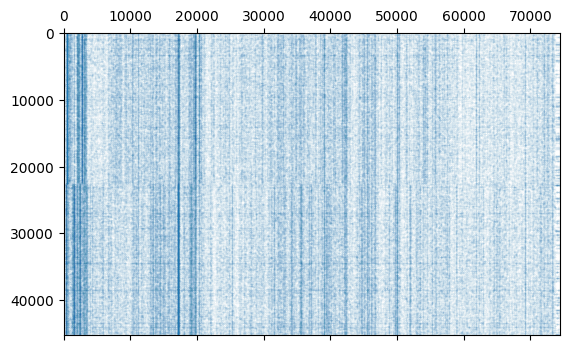

In [ ]:

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cv)

#X_test_tfidf = tfidf_transformer.fit_transform(X_test_cv)

print(X_train_tfidf)
plt.spy(X_train_tfidf, markersize=0.01)


In [ ]:
# train rains a Multinomial Naive Bayes (MNB)
clf = MultinomialNB().fit(X_train_tfidf, X_train.sentiment)

X_test_cv = count_vect.transform(X_test.root_extracted_content_UNTOKENIZED_TEXT)
X_test_tfidf = tfidf_transformer.transform(X_test_cv)
predicted = clf.predict(X_test_tfidf)

print('\nClassification report:')
print(classification_report(X_test.sentiment, predicted))

accuracy = accuracy_score(X_test.sentiment, predicted)
print(':', accuracy)


Classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5768
           1       0.92      0.87      0.89      5752

    accuracy                           0.90     11520
   macro avg       0.90      0.90      0.90     11520
weighted avg       0.90      0.90      0.90     11520

: 0.8962673611111112


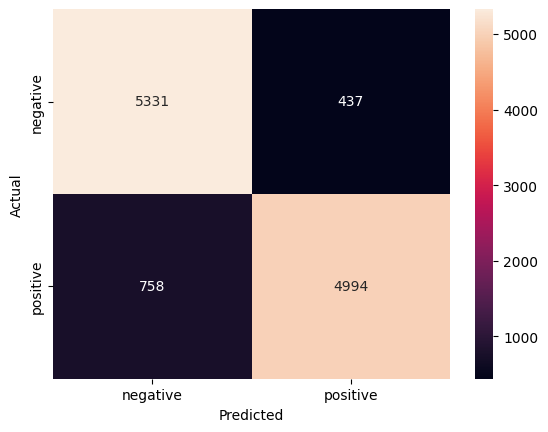

In [ ]:
conf_mat = confusion_matrix(X_test.sentiment, predicted)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model1=LogisticRegression()
model1.fit(X_train_tfidf, X_train.sentiment)

y_model1=model1.predict(X_test_tfidf)

print('\nClassification report:')
print(classification_report(X_test.sentiment,  y_model1))
accuracy = accuracy_score(X_test.sentiment, y_model1)
print('Accuracy:', accuracy)


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5768
           1       0.93      0.95      0.94      5752

    accuracy                           0.94     11520
   macro avg       0.94      0.94      0.94     11520
weighted avg       0.94      0.94      0.94     11520

Accuracy: 0.9377604166666667


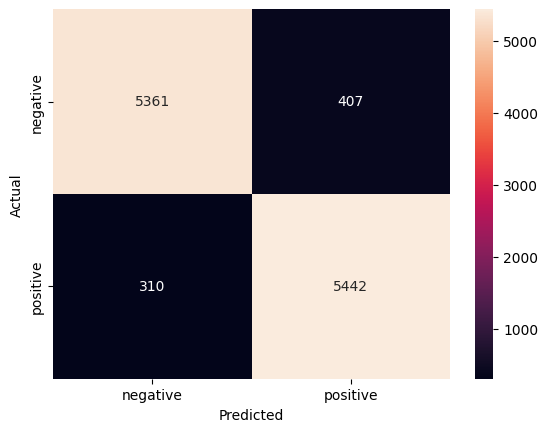

In [ ]:
conf_mat = confusion_matrix(X_test.sentiment,  y_model1)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model3=SVC(kernel='rbf')
model3.fit(X_train_tfidf, X_train.sentiment)

y_model3 = model3.predict(X_test_tfidf)



print('\nClassification report:')
print(classification_report(X_test.sentiment,  y_model3))
accuracy = accuracy_score(X_test.sentiment, y_model3)
print('Accuracy:', accuracy)


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5768
           1       0.94      0.96      0.95      5752

    accuracy                           0.95     11520
   macro avg       0.95      0.95      0.95     11520
weighted avg       0.95      0.95      0.95     11520

Accuracy: 0.9453125


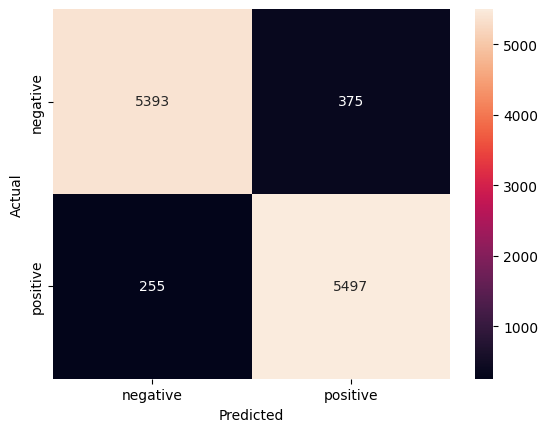

In [ ]:
conf_mat = confusion_matrix(X_test.sentiment,  y_model3)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()